<a href="https://colab.research.google.com/github/LeticiaPaesano/Analise-de-Pagamentos-de-Alugueis/blob/main/Administra%C3%A7%C3%A3o_de_Condom%C3%ADnios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Administração de Condomínios – Análise de Pagamentos de Aluguéis

**Objetivo:** Ler e estruturar os dados de pagamento de aluguéis para detectar atrasos e apoiar a gestão financeira do condomínio.

In [128]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [129]:
# Abrindo o arquivo JSON diretamente (via upload ou local)
with open('/content/dados_locacao_imoveis.json', encoding='utf-8') as f:
    dados_json = json.load(f)

In [130]:
# Extrair a lista de registros da chave principal 'dados_locacao'
dados = dados_json['dados_locacao']

In [131]:
# Inicializar lista para armazenar dados formatados (cada pagamento como uma linha)
linhas_formatadas = []

# Iterar por cada registro, que contém informações do apartamento e listas de datas/valores
for registro in dados:
    apartamento = registro['apartamento']
    datas_combinadas = registro['datas_combinadas_pagamento'] # datas acordadas para pagamento
    datas_pagamento = registro['datas_de_pagamento'] # datas efetivas de pagamento
    valores = registro['valor_aluguel'] # valores pagos em formato texto

# Percorrer simultaneamente as listas para transformar em linhas únicas
    for combinada, realizada, valor in zip(datas_combinadas, datas_pagamento, valores):
# Converter datas para datetime e limpar valores monetários para float
        linhas_formatadas.append({
            'Apartamento': apartamento,
            'Data Acordada': pd.to_datetime(combinada, dayfirst=True),
            'Data Pagamento': pd.to_datetime(realizada, dayfirst=True),
            'Valor Aluguel': float(valor.replace('$', '').replace('reais', '').replace(',', '.').strip())
        })


In [132]:
# Criar DataFrame pandas com os dados estruturados
df_locacao = pd.DataFrame(linhas_formatadas)

# Padronizar nomes das colunas: minúsculas e substituir espaços por underline
df_locacao.columns = df_locacao.columns.str.lower().str.replace(' ', '_')

# Calcular dias de atraso: diferença entre data_pagamento e data_acordada
df_locacao['dias_de_atraso'] = (df_locacao['data_pagamento'] - df_locacao['data_acordada']).dt.days

# Corrigir para não ter valores negativos (considerar 0 se pago em dia ou antecipado)
df_locacao['dias_de_atraso'] = df_locacao['dias_de_atraso'].apply(lambda x: x if x > 0 else 0)

# Criar coluna categórica para status de pagamento
df_locacao['status_pagamento'] = df_locacao['dias_de_atraso'].apply(lambda x: 'Em dia' if x == 0 else 'Em atraso')

# Agrupar dados por apartamento para cálculo de total pago e quantidade de atrasos
valores_totais = df_locacao.groupby('apartamento')['valor_aluguel'].sum().reset_index(name='total_pago')
qtd_atrasos = df_locacao[df_locacao['dias_de_atraso'] > 0].groupby('apartamento').size().reset_index(name='qtd_atrasos')


In [133]:
# Combinar os dois dataframes em resumo consolidado
df_resumo = pd.merge(valores_totais, qtd_atrasos, on='apartamento', how='left')

# Preencher apartamentos sem atrasos com zero
df_resumo['qtd_atrasos'] = df_resumo['qtd_atrasos'].fillna(0).astype(int)

# Calcular a taxa geral de inadimplência (proporção de pagamentos atrasados)
total_lancamentos = len(df_locacao)
total_atrasos = len(df_locacao[df_locacao['dias_de_atraso'] > 0])
taxa_inadimplencia = total_atrasos / total_lancamentos
print(f"Taxa de inadimplência: {taxa_inadimplencia:.2%}")

Taxa de inadimplência: 83.33%


 # Total Recebido por Apartamento

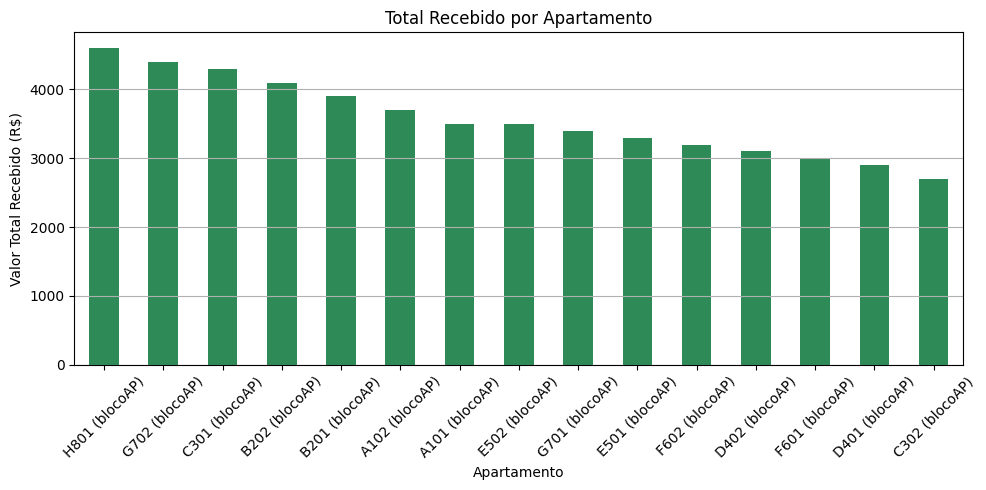

In [134]:
# Gráfico: Total recebido por apartamento
plt.figure(figsize=(10, 5))
df_resumo.sort_values('total_pago', ascending=False).set_index('apartamento')['total_pago'].plot(kind='bar', color='seagreen')
plt.title('Total Recebido por Apartamento')
plt.xlabel('Apartamento')
plt.ylabel('Valor Total Recebido (R$)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Total de Dias em Atraso por Apartamento

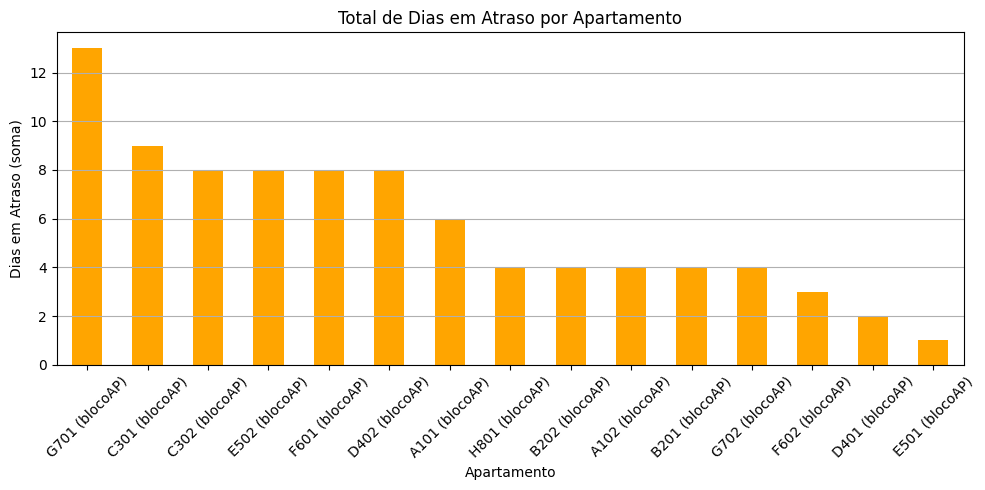

In [135]:
# Agrupar soma dos dias de atraso por apartamento
dias_atraso_total = df_locacao.groupby('apartamento')['dias_de_atraso'].sum().reset_index()

# Gráfico: Dias de atraso por apartamento
plt.figure(figsize=(10, 5))
dias_atraso_total.sort_values('dias_de_atraso', ascending=False).set_index('apartamento')['dias_de_atraso'].plot(kind='bar', color='orange')
plt.title('Total de Dias em Atraso por Apartamento')
plt.xlabel('Apartamento')
plt.ylabel('Dias em Atraso (soma)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Distribuição Geral dos Dias em Atraso

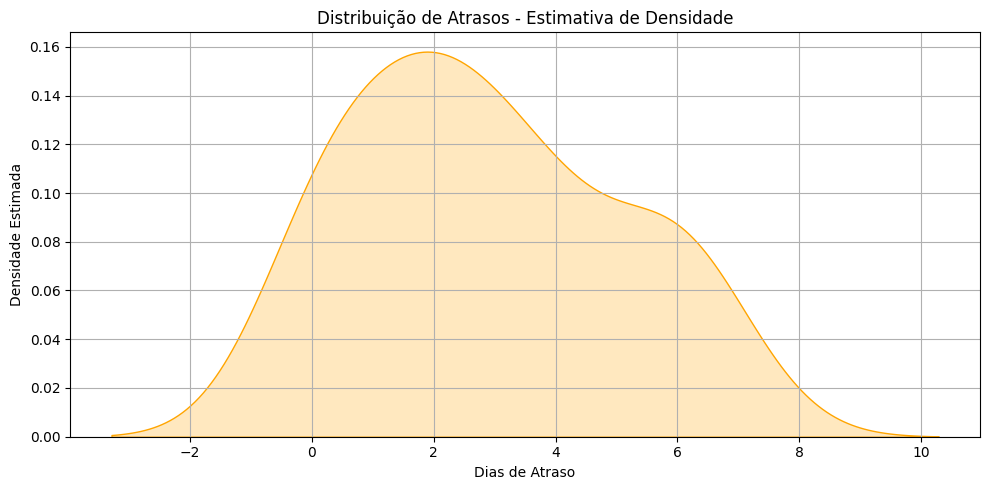

In [136]:
import seaborn as sns

# Gráfico de densidade (KDE) com tamanho padronizado
plt.figure(figsize=(10, 5))
sns.kdeplot(df_locacao['dias_de_atraso'], fill=True, color='orange')
plt.title('Distribuição de Atrasos - Estimativa de Densidade')
plt.xlabel('Dias de Atraso')
plt.ylabel('Densidade Estimada')
plt.grid(True)
plt.tight_layout()
plt.show()

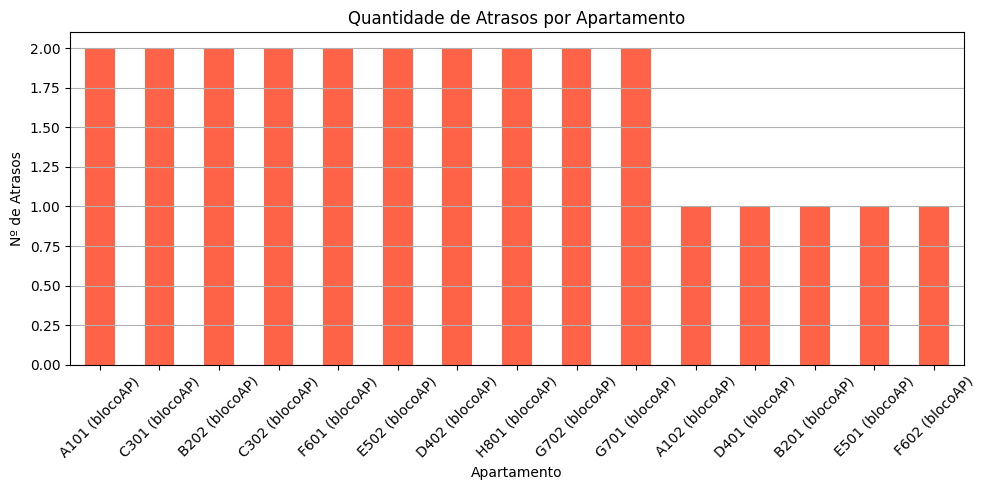

In [137]:
# Visualização: atrasos por apartamento
plt.figure(figsize=(10, 5))
df_resumo.sort_values('qtd_atrasos', ascending=False).set_index('apartamento')['qtd_atrasos'].plot(kind='bar', color='tomato')
plt.title('Quantidade de Atrasos por Apartamento')
plt.xlabel('Apartamento')
plt.ylabel('Nº de Atrasos')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Base tratada com os pagamentos detalhados

In [138]:
# Exportar DataFrame principal com os pagamentos
df_locacao.to_csv('pagamentos_tratados.csv', index=False, encoding='utf-8-sig')

# Resumo por apartamento (total pago + atrasos)

In [139]:
# Exportar resumo consolidado
df_resumo.to_csv('resumo_por_apartamento.csv', index=False, encoding='utf-8-sig')